## Install packages

In [1]:
# Install pandas for data manipulation and numpy for numerical operations
%pip install pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


## Import CSV and import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('CycPeptMPDB_Peptide_All.csv', low_memory=False)
print(len(data))

8466


## Remove duplicates

In [3]:
data = data.drop_duplicates(subset='Structurally_Unique_ID')
print(len(data))

7991


## Distribution by Source and by Year

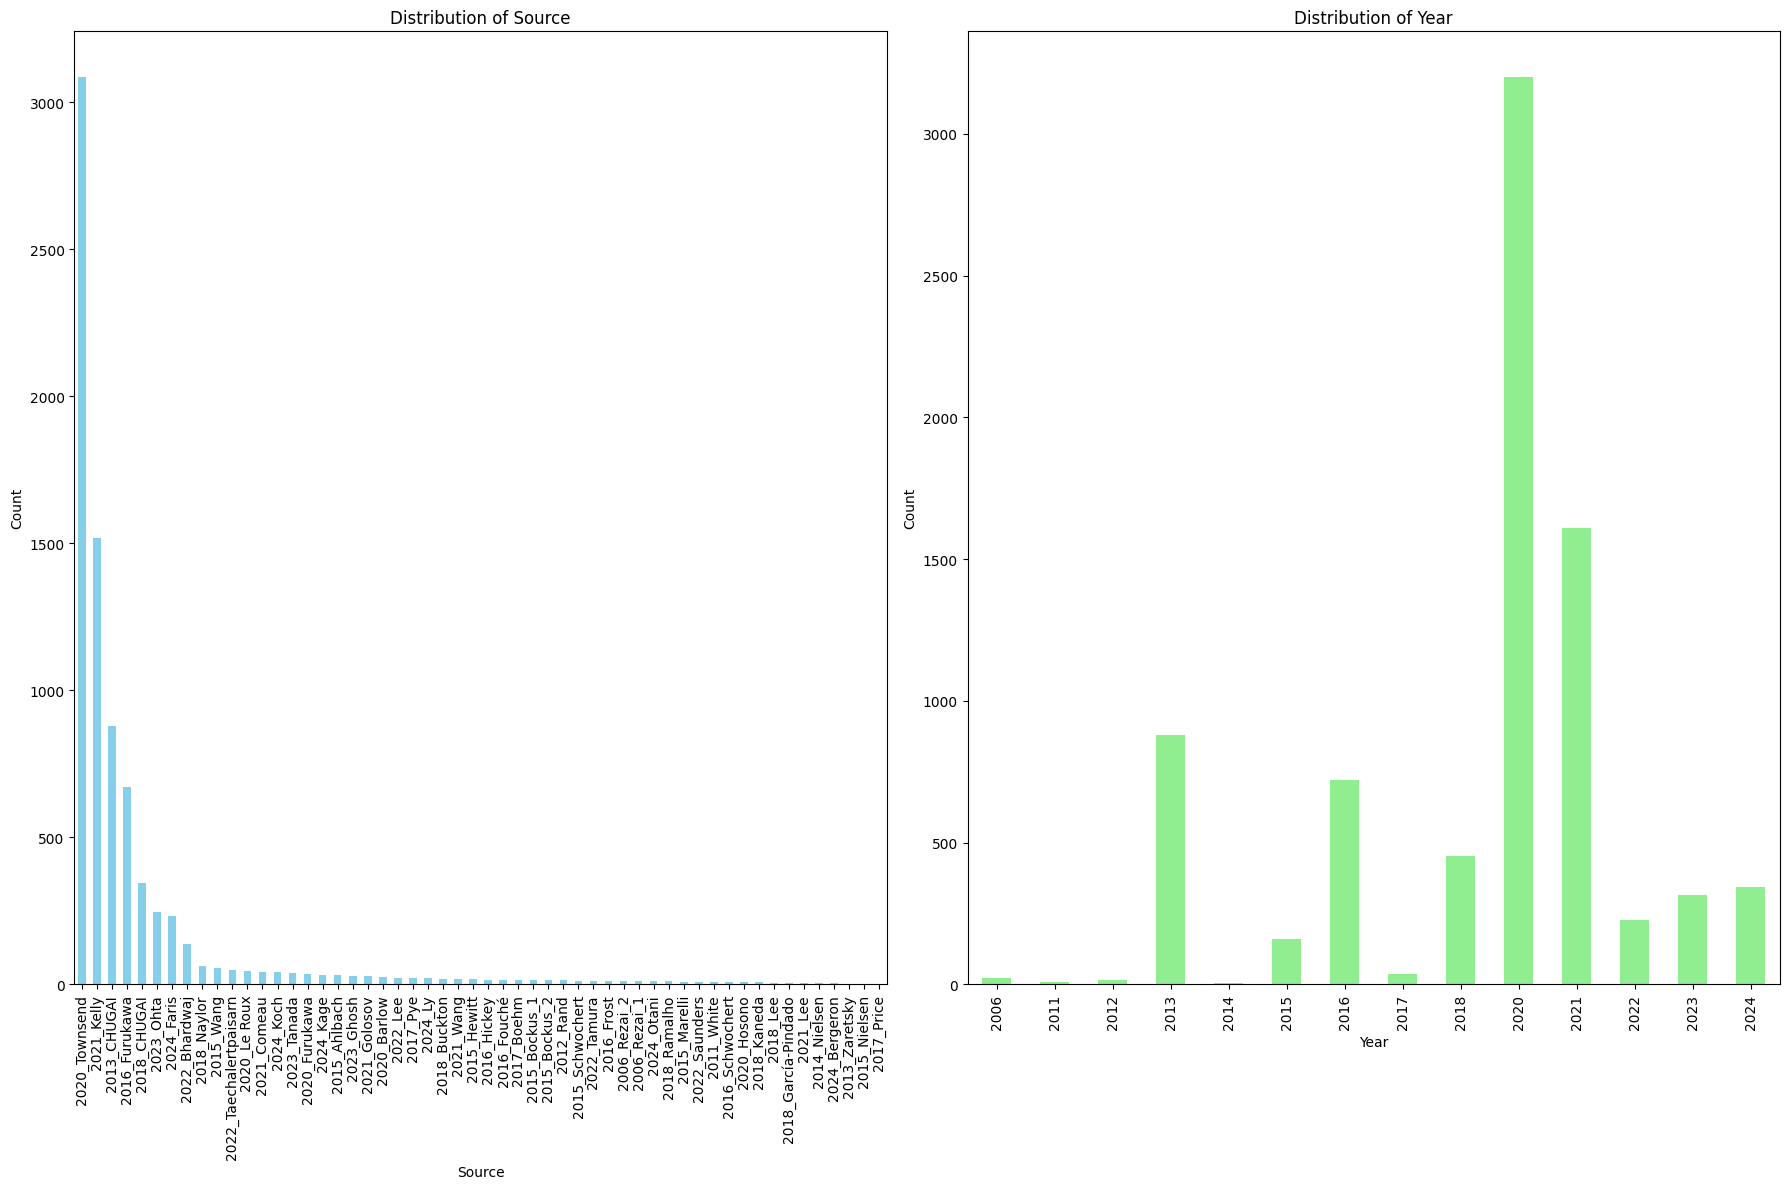

In [4]:
# Create a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# Plot the distribution of the 'Source' column
data['Source'].value_counts().plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Source')
axes[0].set_xlabel('Source')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# Plot the distribution of the 'Year' column
data['Year'].value_counts().sort_index().plot(kind='bar', color='lightgreen', ax=axes[1])
axes[1].set_title('Distribution of Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


## Peptide Identity & Sequence Features

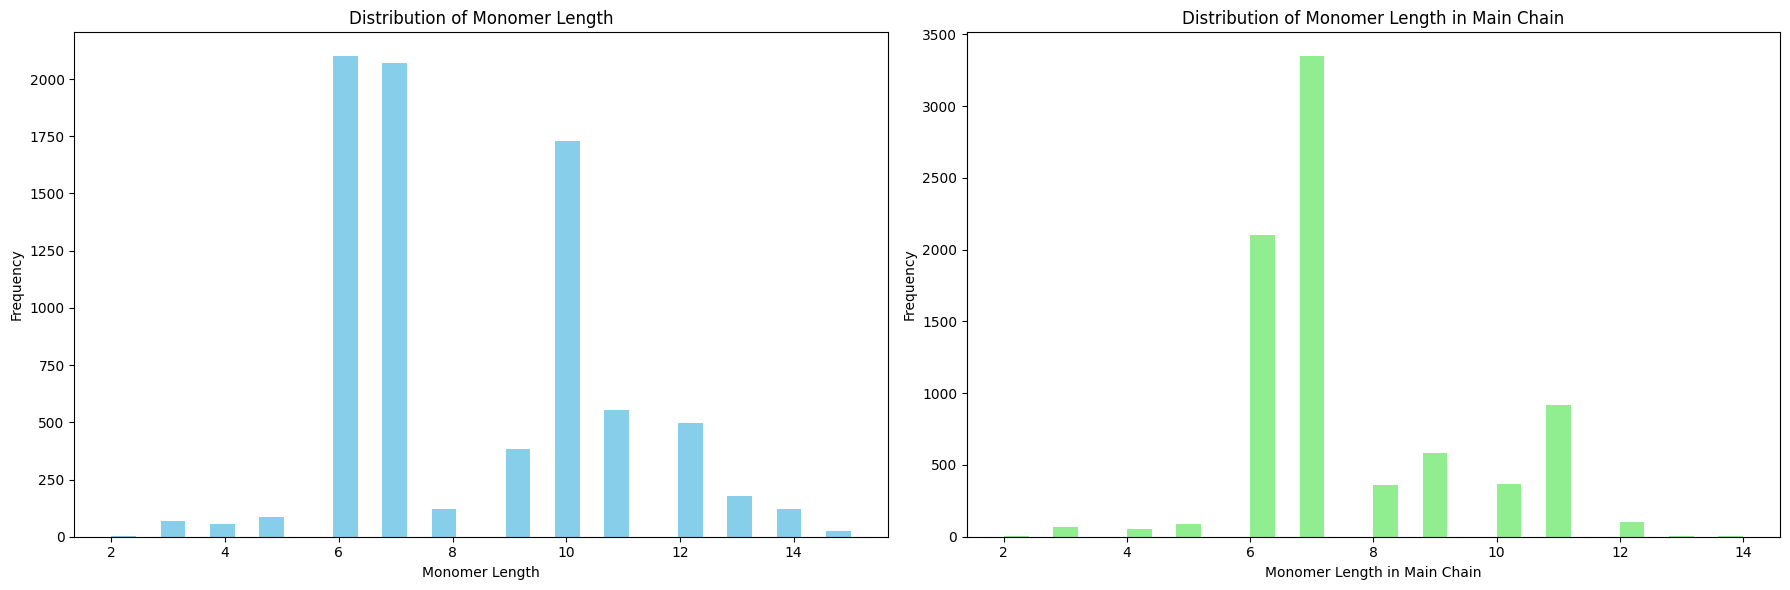

In [5]:
from collections import Counter
import itertools

# Peptide sequence stats
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Length distribution: Monomer_Length
data['Monomer_Length'].plot(kind='hist', bins=30, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Monomer Length')
axes[0].set_xlabel('Monomer Length')
axes[0].set_ylabel('Frequency')

# Length distribution: Monomer_Length_in_Main_Chain
data['Monomer_Length_in_Main_Chain'].plot(kind='hist', bins=30, color='lightgreen', ax=axes[1])
axes[1].set_title('Distribution of Monomer Length in Main Chain')
axes[1].set_xlabel('Monomer Length in Main Chain')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
import ast

# RUN THIS CELL ONLY ONCE
data['Sequence'] = data['Sequence'].apply(ast.literal_eval) # Convert string representation of list to actual list

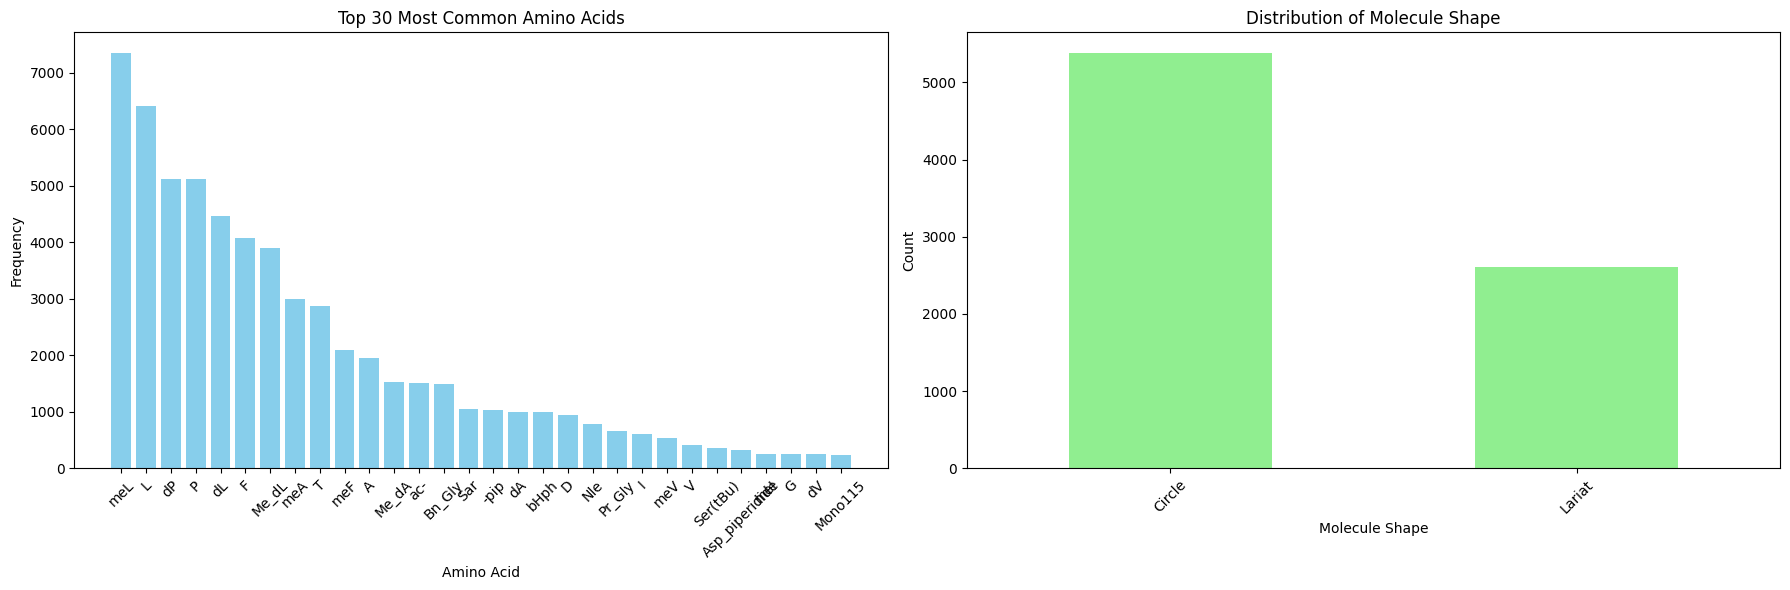

In [19]:
import pandas as pd

# Flatten all amino acids into a single list
all_aas = [aa for seq in data['Sequence'] for aa in seq]

# Count frequency
aa_counts = Counter(all_aas)

# Sort by frequency (descending)
sorted_aa_counts = sorted(aa_counts.items(), key=lambda x: x[1], reverse=True)

# Convert to DataFrame for easy viewing or plotting
aa_freq_df = pd.DataFrame(sorted_aa_counts, columns=["AminoAcid", "Frequency"])

# Plot the top 10 most common amino acids
top_10_aa = aa_freq_df.head(30)

# Create a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the top 30 most common amino acids
axes[0].bar(top_10_aa['AminoAcid'], top_10_aa['Frequency'], color='skyblue')
axes[0].set_title('Top 30 Most Common Amino Acids')
axes[0].set_xlabel('Amino Acid')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plot the distribution of Molecule_Shape
data['Molecule_Shape'].value_counts().plot(kind='bar', color='lightgreen', ax=axes[1])
axes[1].set_title('Distribution of Molecule Shape')
axes[1].set_xlabel('Molecule Shape')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

## Permeability Annotations

Caco2, MDCK, and RRCK all have the majority annotated as "NaN"

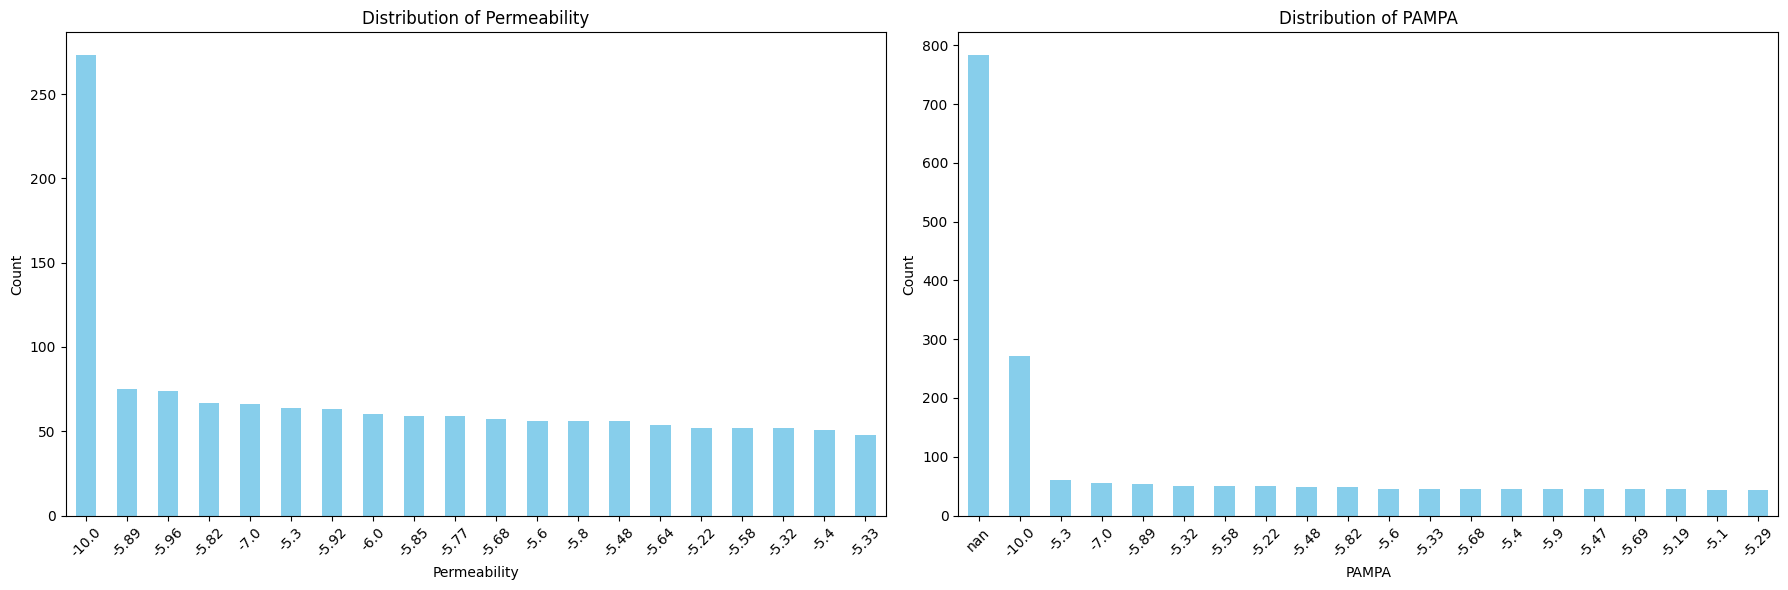

In [ ]:
fields_to_plot = ['Permeability', 'PAMPA']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, field in enumerate(fields_to_plot):
    if field in data.columns:
        data[field].value_counts(dropna=False).head(20).plot(kind='bar', ax=axes[i], color='skyblue')
        axes[i].set_title(f'Distribution of {field}')
        axes[i].set_xlabel(field)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Structure Information

In [ ]:
# Check for presence/absence of 3D information
data['Has_3D_Info'] = data['_3DPSA'].notnull()
print(f"Entries with 3D information: {data['Has_3D_Info'].sum()}")
print(f"Entries without 3D information: {len(data) - data['Has_3D_Info'].sum()}")

# Check sequence-structure concordance
sequence_smiles_concordance = data.apply(
    lambda row: row['Sequence'] is not None and row['SMILES'] is not None, axis=1
)
print(f"Entries with both Sequence and SMILES: {sequence_smiles_concordance.sum()}")
print(f"Entries missing either Sequence or SMILES: {len(data) - sequence_smiles_concordance.sum()}")


Entries with 3D information: 13
Entries without 3D information: 7978
Entries with both Sequence and SMILES: 7991
Entries missing either Sequence or SMILES: 0
